In [14]:
import sys
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
# import sklearn as sk
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.model_selection import cross_val_score
# from sklearn.tree import DecisionTreeClassifier

In [2]:
KB=1024
MB=KB*1024
GB=MB*1024
TB=GB*1024

In [3]:
df = pd.read_parquet('data/xcache_2022-06-01.parquet')  
df.drop(columns=['host'],inplace=True)
df.head()

,access,site,lfn,scope,fn,b_hit,b_miss,b_bypass,fsize,fill
0,2,AGLT2,atlas/rucio/mc15_13TeV/6f/1a/EVNT.27585588._00...,mc15_13TeV,EVNT.27585588._000719.pool.root.1,364496131,33432150,0,398338556,1.000000
1,2,AGLT2,atlas/rucio/mc15_13TeV/f8/f2/EVNT.27585588._00...,mc15_13TeV,EVNT.27585588._001775.pool.root.1,363018480,34105107,0,397532163,1.000000
2,2,AGLT2,atlas/rucio/mc15_13TeV/d5/fb/EVNT.27585588._00...,mc15_13TeV,EVNT.27585588._001661.pool.root.1,363880281,33804761,0,398093435,1.000000
3,8,BNL,atlas/rucio/data17_13TeV/48/63/DAOD_EXOT2.1986...,data17_13TeV,DAOD_EXOT2.19869372._000158.pool.root.1,307294784,0,0,874949234,0.721390
4,21,BNL,atlas/rucio/user/pfalke/96/b3/user.pfalke.2769...,user.pfalke,user.pfalke.27690994._001499.output.root,406370,4885409,0,2737217806,0.052768


In [4]:
def Acc(r):
    cols = ['Accesses','tot files','avg acc per file', 'fill']
    return pd.Series( (
            r.access.sum(), r.shape[0], r.access.sum()/r.shape[0], 
            r.fill.mean())
            , index=cols)

def perc_read(r):
    cols = ['accesses', 'read perc', 'tot hit [TB]', 'tot miss[TB]', 'tot bypass [TB]']
    return pd.Series( 
        ( r.shape[0],  
         ( r.b_hit.sum() + r.b_miss.sum() + r.b_bypass.sum() ) / r.fsize.sum(),
         r.b_hit.sum()/TB, 
         r.b_miss.sum()/TB, 
         r.b_bypass.sum()/TB 
        ) ,
        index=cols
    )


In [5]:
df['ext']=df.fn.str.split('.').str[-2]+'.'+df.fn.str.split('.').str[-1]

df['ext1'] = np.where(df['ext'].str.find('root')>-1, 'root', df['ext'] )
df['ext1'] = np.where(df['ext1'].str.endswith('.1'), 'root', df['ext1'] )

df.groupby('ext1').apply(perc_read).sort_values('accesses',ascending=False).head()

,accesses,read perc,tot hit [TB],tot miss[TB],tot bypass [TB]
ext1,,,,,
root,4367401.0,0.165634,967.588444,363.297446,20.897982
log.tgz,215860.0,0.999972,0.046615,0.023193,0.000726
lib.tgz,95882.0,1.191513,6.584221,0.179301,0.016355
output.h5,1616.0,1.000794,0.483231,0.160896,0.000000
tar.gz,903.0,0.943259,0.014212,0.003880,0.000000


In [6]:
perc_read(df)

accesses           4.681871e+06
read perc          1.664243e-01
tot hit [TB]       9.747791e+02
tot miss[TB]       3.637137e+02
tot bypass [TB]    2.091506e+01
dtype: float64

prints percentage of file read in an average access.
Total data delivered on hit (in TB), on miss, and bypassed.

the same but grouped per scope

In [7]:
print(df.groupby('scope').apply(perc_read).sort_values('accesses',ascending=False).to_string())

                 accesses  read perc  tot hit [TB]  tot miss[TB]  tot bypass [TB]
scope                                                                            
mc16_13TeV      1621651.0   0.132937  3.992653e+02  2.307652e+02     1.014334e+01
data18_13TeV     736960.0   0.199064  1.479719e+02  4.630360e+01     4.806284e+00
panda            684600.0   1.033744  2.189840e+01  4.741724e+00     1.924114e-01
mc15_13TeV       439249.0   0.288118  1.615325e+00  1.240362e+00     0.000000e+00
data17_13TeV     297249.0   0.316342  1.000577e+02  2.588172e+01     3.206215e+00
data16_13TeV     289179.0   0.454897  1.202956e+02  2.346653e+01     1.943588e+00
user.stkazako    141570.0   0.000805  9.131096e-02  2.307229e-01     1.875329e-04
data15_13TeV      72095.0   0.220195  1.214677e+01  2.627009e+00     1.253473e-01
user.pfalke       51453.0   0.002287  8.529001e-02  4.942675e-01     0.000000e+00
phys-exotics      47502.0   0.005843  5.055730e-01  8.141562e-01     4.561911e-04
user.nbruscin   

and grouped by site

In [8]:
print(df.groupby('site').apply(perc_read).sort_values('accesses',ascending=False).to_string())

             accesses  read perc  tot hit [TB]  tot miss[TB]  tot bypass [TB]
site                                                                         
MWT2        1693568.0   0.094827    153.139817    119.388625         1.027513
AGLT2       1139053.0   0.090452    121.777575    100.863091         2.236732
NET2         677395.0   0.678729    512.762376     82.455900        17.650819
BNL          502404.0   0.145985     90.693096     23.366053         0.000000
LRZ-LMU      177954.0   0.148214     36.173795     10.493323         0.000000
SWT2         164956.0   0.089432     18.476801     19.300001         0.000000
Birmingham   163857.0   0.104666     11.053031      3.901255         0.000000
praguelcg2   162684.0   0.148729     30.702659      3.945403         0.000000


total number of accesses. number of unique files. average number of times files were accessed, and current file fill factor.

In [9]:
idx = df.groupby(['lfn'])['access'].transform(max) == df['access']
mdf = df[idx]
print(Acc(mdf))

Accesses            5.013969e+06
tot files           1.271288e+06
avg acc per file    3.944007e+00
fill                8.988877e-01
dtype: float64


                 Accesses  tot files  avg acc per file      fill
scope                                                           
mc16_13TeV      1596559.0   227556.0          7.016115  0.739315
data18_13TeV    1032229.0   122145.0          8.450849  0.768549
panda            684750.0   591651.0          1.157355  0.993794
mc15_13TeV       433781.0   116448.0          3.725105  0.998665
data16_13TeV     344636.0    61673.0          5.588118  0.889068
data17_13TeV     328646.0    67536.0          4.866234  0.822979
data15_13TeV     100511.0    11355.0          8.851695  0.834995
user.stkazako     80546.0      443.0        181.819413  0.403915
phys-exotics      57371.0      995.0         57.659296  0.466399
user.pfalke       44194.0      710.0         62.245070  0.271808
user.nbruscin     40253.0     1676.0         24.017303  0.999925
user.calfayan     37245.0      184.0        202.418478  0.999751
user.nibrahim     30994.0      288.0        107.618056  0.487499
mc20_13TeV        30511.0

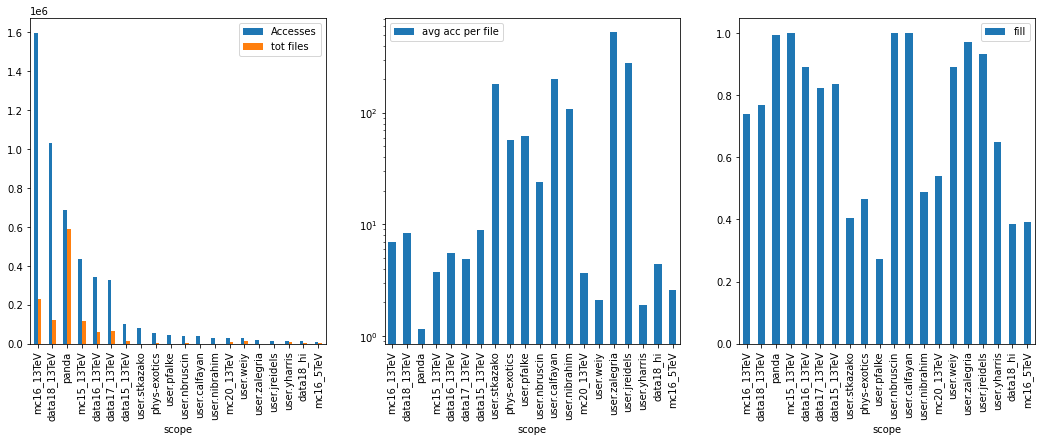

In [38]:
groups=mdf.groupby('scope').apply(Acc).sort_values('Accesses',ascending=False)
print(groups.to_string())

fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
groups[:20].plot.bar( y=['Accesses','tot files'], ax=ax1)
groups[:20].plot.bar( y=['avg acc per file'], ax=ax2, logy=True)
groups[:20].plot.bar( y=['fill'], ax=ax3)
fig.set_size_inches(18, 6)
plt.show()
# fig.savefig('accesses and files per scope.png', dpi=100)

             Accesses  tot files  avg acc per file      fill
site                                                        
MWT2        1552881.0   359148.0          4.323791  0.879818
AGLT2       1416846.0   160150.0          8.846993  0.742648
NET2         663398.0   348430.0          1.903963  0.963934
BNL          441037.0   223291.0          1.975167  0.972856
LRZ-LMU      408749.0    40739.0         10.033359  0.677242
SWT2         187879.0    23739.0          7.914360  0.682557
Birmingham   178188.0   102798.0          1.733380  0.974825
praguelcg2   164991.0    12993.0         12.698453  0.825690


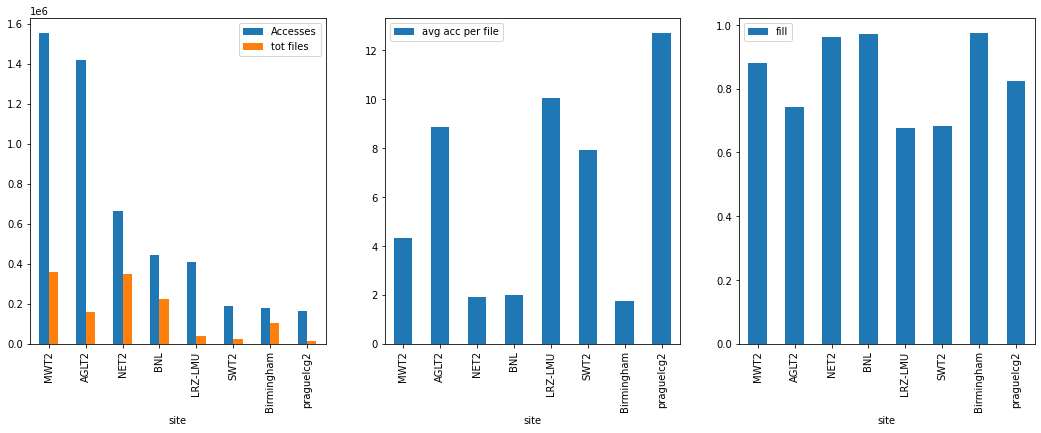

In [41]:
groups=mdf.groupby('site').apply(Acc).sort_values('Accesses',ascending=False)
print(groups.to_string())

fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
groups.plot.bar( y=['Accesses','tot files'], ax=ax1)
groups.plot.bar( y=['avg acc per file'], ax=ax2, logy=False)
groups.plot.bar( y=['fill'], ax=ax3)
fig.set_size_inches(18, 6)
plt.show()
# fig.savefig('accesses and files per scope.png', dpi=100)

Frequently accessed files

In [12]:
print(mdf.groupby('ext1').apply(Acc).sort_values('Accesses',ascending=False).to_string())

                    Accesses  tot files  avg acc per file      fill
ext1                                                               
root               4699066.0  1044792.0          4.497609  0.878639
log.tgz             215856.0   213141.0          1.012738  0.992688
lib.tgz              96061.0    10952.0          8.771092  0.988173
output.h5             1616.0     1616.0          1.000000  1.000000
tar.gz                 880.0      656.0          1.341463  0.998659
28224148._0001          70.0        2.0         35.000000  0.102272
_0002.2                 52.0       20.0          2.600000  0.439503
28224193._0002          51.0        1.0         51.000000  0.207170
26729008._              39.0        1.0         39.000000  1.000000
_0001.2                 39.0       18.0          2.166667  0.351662
_0003.2                 35.0       15.0          2.333333  0.365523
28224148._0000          33.0        1.0         33.000000  0.088209
_0001.data              19.0       17.0         

In [13]:

# ldf.index = pd.to_datetime(ldf["time"])
# # ldf.plot(y=["loss"],figsize=(15,4), style='.')
# groups = ldf.groupby("host")
# for name, group in groups:
#     # plt.plot()
#     plt.plot(group["loss"], marker="o", linestyle="", label=name)
# plt.legend()
# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(18.5, 10.5)
# # fig.savefig('losses.png', dpi=100)